# Analytics and Programming for Health Wearables, ex 1

Milja Lempinen

In [1]:
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

# 1. Reading signal files

<font color = green> Using the two inspected and filtered signals from last week

In [2]:
data_source_ecg = 'data2/filtered_ecg_data.csv'
data_source_ppg = 'data2/filtered_ppg_data.csv'

In [3]:
df_ecg = pd.read_csv(data_source_ecg, index_col=0)
df_ppg = pd.read_csv(data_source_ppg, index_col=0)

In [4]:
print(df_ecg.head())
print(df_ppg.head())

   ecg_time     ecg_sig
0     0.000  136.128132
1     0.005  256.981026
2     0.010  370.933553
3     0.015  468.601759
4     0.020  541.858765
   ppg_time   ppg_sig
0     0.000 -0.102489
1     0.005 -0.507563
2     0.010 -1.301734
3     0.015 -2.460474
4     0.020 -3.955136


# 1. Peak detection of signals

In [5]:
def peak_detection(signal, min_height):
    peaks = sp.signal.find_peaks(signal, height = min_height)
    return peaks

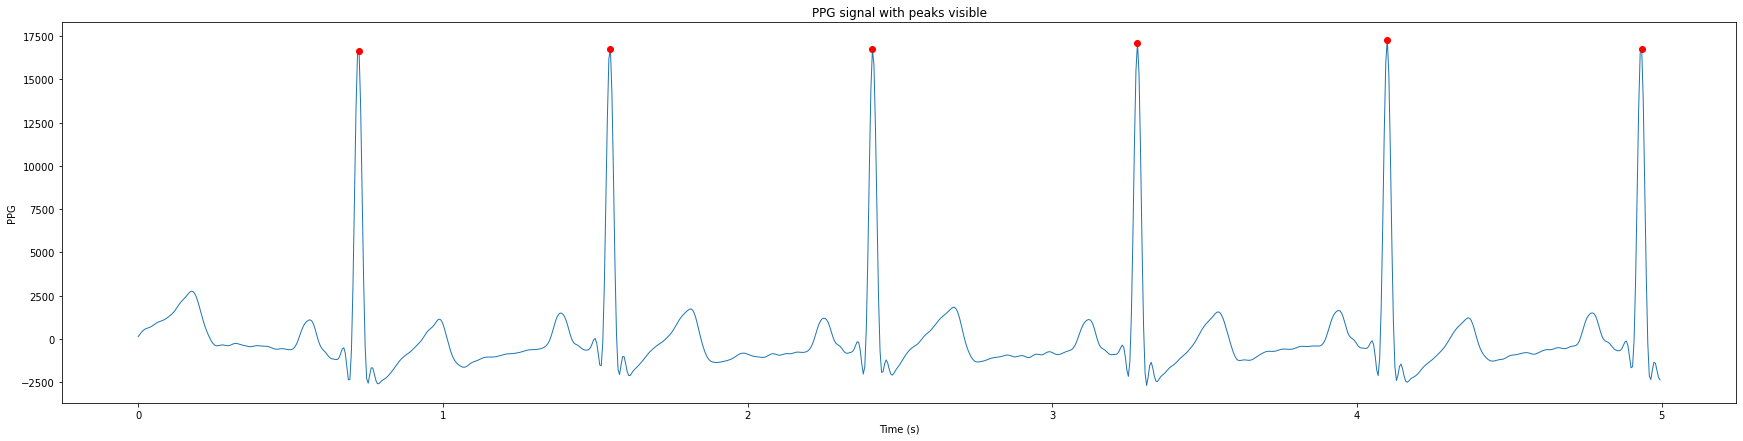

In [6]:
ecg_time = df_ecg['ecg_time'].to_numpy()
ecg_sig = df_ecg['ecg_sig'].to_numpy()

peaks_ecg = peak_detection(ecg_sig, 5000)

first_k_ecg = peak_detection(ecg_sig[0:1000], 5000)

fig = plt.figure(figsize=(30,7))
plt.plot(ecg_time[0:1000], ecg_sig[0:1000], label="filtered signal", linewidth=1)
plt.title("PPG signal with peaks visible")
plt.xlabel("Time (s)")
plt.ylabel("PPG")
plt.plot(ecg_time[first_k_ecg[0]],ecg_sig[first_k_ecg[0]],"ro")
plt.show()

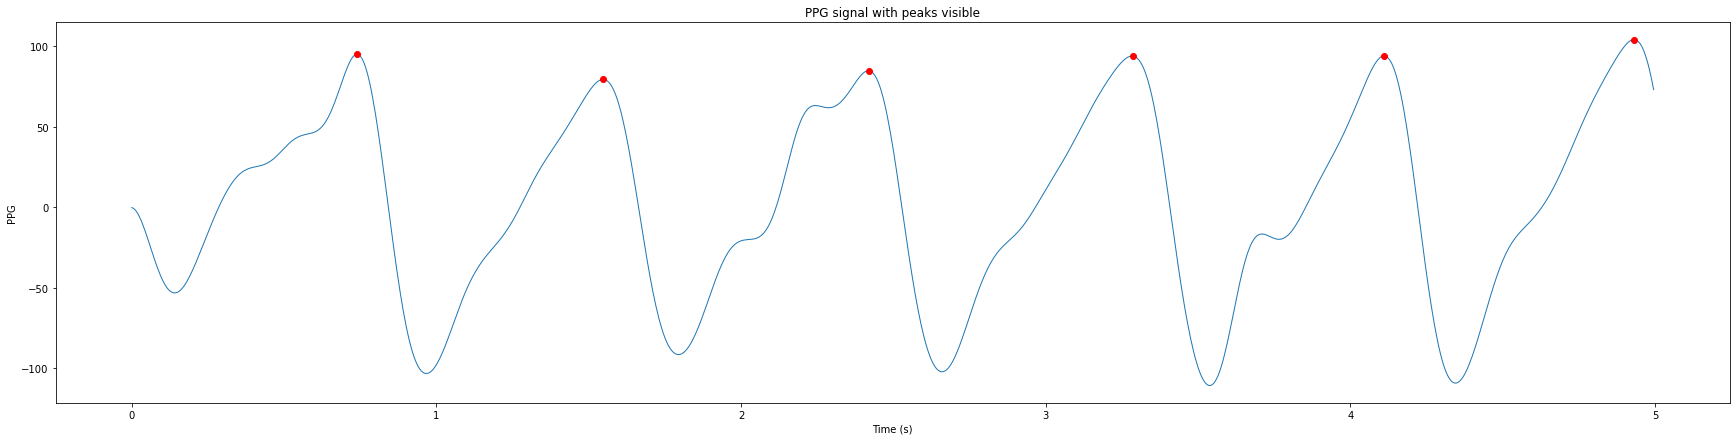

In [40]:
ppg_time = df_ppg['ppg_time'].to_numpy()
ppg_sig = df_ppg['ppg_sig'].to_numpy()

peaks_ppg = peak_detection(ppg_sig, 75)

first_k_ppg = peak_detection(ppg_sig[0:1000], 75)

fig = plt.figure(figsize=(30,7))
plt.plot(ppg_time[0:1000], ppg_sig[0:1000], label="filtered signal", linewidth=1)
plt.title("PPG signal with peaks visible")
plt.xlabel("Time (s)")
plt.ylabel("PPG")
plt.plot(ppg_time[first_k_ppg[0]],ppg_sig[first_k_ppg[0]],"ro")
plt.show()

<font color=green> With this solution we get all peaks. If only R-peak is desired the modifications would be needed. 

# 2. Heart rate

In [8]:
#Computing heart rate without doing any tricks

RR_intervals_ecg = np.diff(ecg_time[peaks_ecg[0]])
RR_intervals_ppg = np.diff(ppg_time[peaks_ppg[0]])

rr_average_ecg = np.mean(RR_intervals_ecg)
rr_average_ppg = np.mean(RR_intervals_ppg)

heart_rate_ppg = 60.0/rr_average_ppg 
print('Heart rate in the ppg signal: '+str(round(heart_rate_ppg, 2))+'bps')

heart_rate_ecg = 60.0/rr_average_ecg 
print('Heart rate in the ecg signal: '+str(round(heart_rate_ecg, 2))+'bps')

Heart rate in the ppg signal: 73.22bps
Heart rate in the ecg signal: 73.3bps


<font color=green>The removal of non-qualifying peaks was already done, but it would be easy: removing intervals that do not fit the heartbeat interval standard from the rr_intervals array and then recalculating.

# 3. HRV

<font color=green> To be fair, I had no idea what was happening here. The signal should be divided into smaller segments and then calculate the heart rates of these segments and then the variance between those. 

In [82]:
#FROM MATPLOTLIB DOCS

def lorenz(x, y, s=10, r=28, b=2.667):
    """
    Given:
       x, y, z: a point of interest in three dimensional space
       s, r, b: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    """
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    return x_dot, y_dot

xs = ecg_time
ys = peaks_ecg[0]

dt = 0.01
for i in range(len(peaks_ecg)):
    x_dot, y_dot = lorenz(ecg_time, peaks_ecg)
    xs[i + 1] = ys[i] + (x_dot * dt)
    ys[i + 1] = ys[i] + (y_dot * dt)


# Plot
ax = plt.figure().add_subplot(projection='3d')

ax.plot(xs, ys, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_title("Lorenz Attractor")

plt.show()

<ipython-input-82-8519d257465a>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_dot = s*(y - x)


ValueError: operands could not be broadcast together with shapes (2,) (24492,) 

# 4. Average time delay

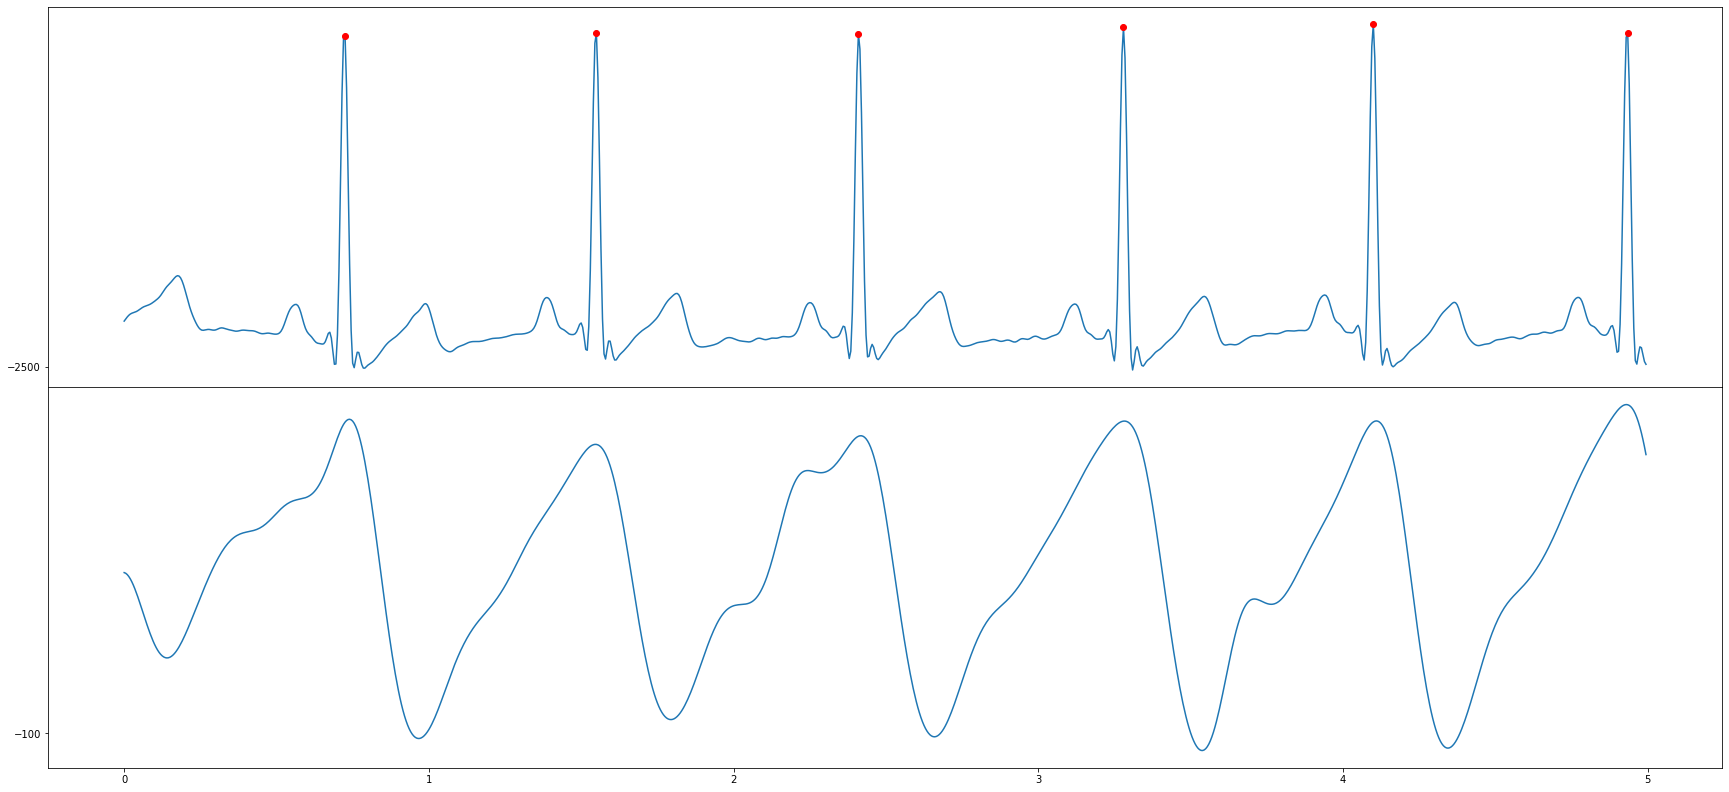

In [11]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(30,14))
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)

# Plot each graph, and manually set the y tick values
axs[0].plot(ecg_time[0:1000], ecg_sig[0:1000])
axs[0].plot(ecg_time[first_k_ecg[0]],ecg_sig[first_k_ecg[0]],"ro")
axs[0].set_yticks(np.arange(-2500, 0.0, 17500))

axs[1].plot(ecg_time[0:1000], ppg_sig[0:1000])
axs[1].set_yticks(np.arange(-100, 0.0, 100))

plt.show()


In [76]:
#Estimating that the foot of the ppg is next from low peak, because it is where the direction changes.

def foot_detection(signal):
    peaks = sp.signal.find_peaks(-signal, height = 50)
    feet = peaks[0]+1
    return feet

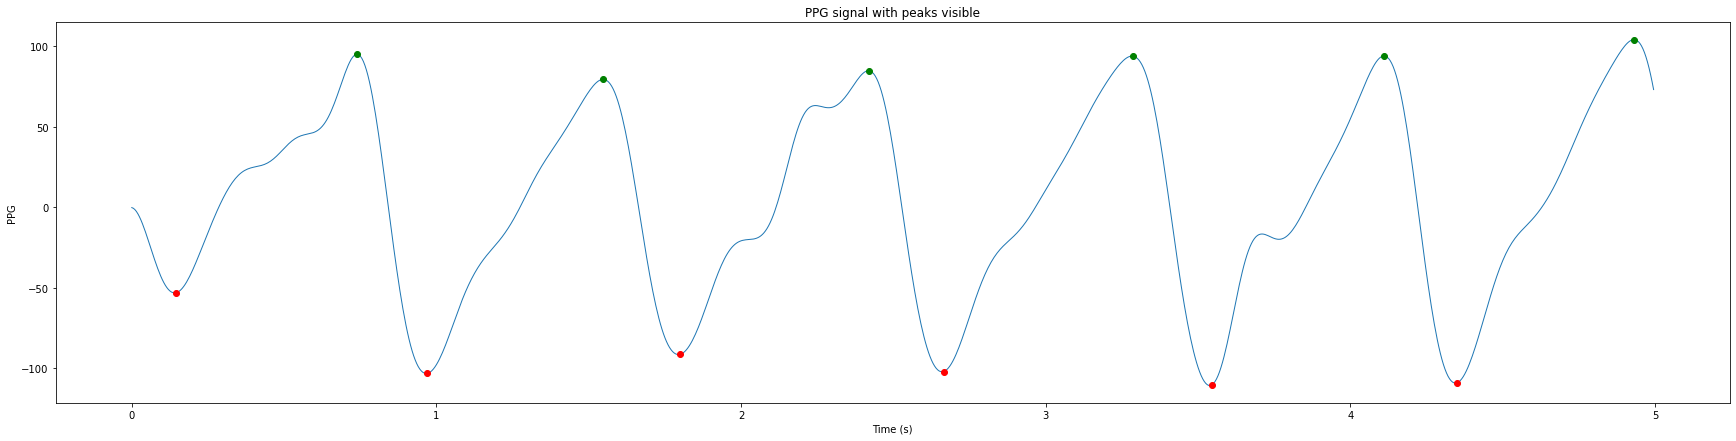

In [77]:
foot_ppg = foot_detection(ppg_sig)

first_k_feet = foot_detection(ppg_sig[0:1000])

fig = plt.figure(figsize=(30,7))
plt.plot(ppg_time[0:1000], ppg_sig[0:1000], label="filtered signal", linewidth=1)
plt.title("PPG signal with peaks visible")
plt.xlabel("Time (s)")
plt.ylabel("PPG")
plt.plot(ppg_time[first_k_feet],ppg_sig[first_k_feet],"ro")
plt.plot(ppg_time[first_k_ppg[0]],ppg_sig[first_k_ppg[0]],"go")
plt.show()

In [78]:
def r_to_foot(feet, r_peaks):
    foot_r_array = []
    x=0
    if feet[0]>r_peaks[0]:
        for i in range(0, (len(feet)+len(r_peaks))):
            foot_r_array.append(r_peaks[x])
            foot_r_array.append(feet[x])
            x=+1
        foot_r_array.append(0)
    else:
        for i in range(0, (len(feet)+len(r_peaks))):
            foot_r_array.append(feet[x])
            foot_r_array.append(r_peaks[x])
            x=+1
        foot_r_array.append(1)
    return foot_r_array
        

In [79]:
feet = r_to_foot(foot_ppg, peaks_ppg[0])
print(feet[len(feet)-1])

foot_to_r_intervals = np.diff(ppg_time[feet[0:(len(feet)-1)]])

mean_ftr = np.mean(foot_to_r_intervals)
print(mean_ftr)

1
0.002376910016977929


In [ ]:
#Something's a bit off here... Would like to fix later